# Kaggle Based Models

This notebook produces predictive models on the kaggle dataset. The train, test and weather data are used from the original Kaggle competition. This allows us to at-least have some idea of the types of modeling, their performances etc, before we switch to our own train+validation+test splits and additional predictors.

To be honest, if this approach works, well, perhaps we can continue using it?

In [158]:
library("tidyverse")
library("xts")
library("dygraphs")
library("janitor")

## Import the training data

In [159]:
kag_train <- read_csv("../data/raw/kaggle/train.csv") %>% clean_names()
kag_train %>% sample_n(10)

Parsed with column specification:
cols(
  Date = col_date(format = ""),
  Address = col_character(),
  Species = col_character(),
  Block = col_integer(),
  Street = col_character(),
  Trap = col_character(),
  AddressNumberAndStreet = col_character(),
  Latitude = col_double(),
  Longitude = col_double(),
  AddressAccuracy = col_integer(),
  NumMosquitos = col_integer(),
  WnvPresent = col_integer()
)


date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
2007-09-05,"West 37th Place, Chicago, IL, USA",CULEX PIPIENS,81,W 37TH PL.,T157,"8100 W 37TH PL., Chicago, IL",41.82590,-87.66783,5,1,0
2013-08-15,"6000 West Montrose Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,60,W MONTROSE DR,T017,"6000 W MONTROSE DR, Chicago, IL",41.96062,-87.77719,9,4,0
2013-06-27,"1700 North Ashland Avenue, Chicago, IL 60622, USA",CULEX RESTUANS,17,N ASHLAND AVE,T232,"1700 N ASHLAND AVE, Chicago, IL",41.91256,-87.66805,9,1,0
2009-07-17,"2500 West Grand Avenue, Chicago, IL 60654, USA",CULEX RESTUANS,25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.89112,-87.65449,8,9,0
2013-08-01,"University of Illinois at Chicago, 1100 South Ashland Avenue, Chicago, IL 60607, USA",CULEX PIPIENS/RESTUANS,11,S ASHLAND AVE,T090,"1100 S ASHLAND AVE, Chicago, IL",41.86808,-87.66690,9,24,0
2007-08-15,"2000 East 111th Street, Chicago, IL 60628, USA",CULEX PIPIENS,20,E 111TH ST,T084,"2000 E 111TH ST, Chicago, IL",41.69255,-87.59887,8,9,0
2013-07-25,"6100 North Lemont Avenue, Chicago, IL 60646, USA",CULEX PIPIENS/RESTUANS,61,N LEMONT AVE,T012,"6100 N LEMONT AVE, Chicago, IL",41.99143,-87.74711,8,31,0
2007-07-11,"5200 South Nordica Avenue, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,52,S NORDICA,T070,"5200 S NORDICA, Chicago, IL",41.79762,-87.79789,8,2,0
2011-09-23,"7000 West Armitage Avenue, Chicago, IL 60707, USA",CULEX PIPIENS,70,W ARMITAGE AVENUE,T151,"7000 W ARMITAGE AVENUE, Chicago, IL",41.91627,-87.80052,8,3,0
2009-06-19,"1200 West Greenleaf Avenue, Chicago, IL 60626, USA",CULEX RESTUANS,12,W GREENLEAF AVE,T018,"1200 W GREENLEAF AVE, Chicago, IL",42.01041,-87.66214,8,1,0


There seem to be instances where the same date+trap_id is used, even the same species, yet data is spread over 2 rows. Why? I'm consolidating this first..

In [160]:
kag_train[615:635,]

date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,1
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0


In [161]:
kag_train[578:579,]

date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
2007-07-19,"South Torrence Avenue, Chicago, IL, USA",CULEX PIPIENS,13,S TORRENCE AVE,T200,"1300 S TORRENCE AVE, Chicago, IL",41.67862,-87.55931,5,7,0
2007-07-19,"South Torrence Avenue, Chicago, IL, USA",CULEX PIPIENS,13,S TORRENCE AVE,T200,"1300 S TORRENCE AVE, Chicago, IL",41.67862,-87.55931,5,2,0


So my logic is : for each [date + trap id + species], add up the mosq count and the wnv count.

In [162]:
mosq_by_date = kag_train %>% group_by(date,trap,species) %>% summarise(total_mosq=sum(num_mosquitos),total_wnv = sum(wnv_present)) %>% ungroup()
mosq_by_date %>% sample_n(10)

date,trap,species,total_mosq,total_wnv
2009-09-14,T147,CULEX PIPIENS/RESTUANS,1,0
2007-07-27,T049,CULEX PIPIENS/RESTUANS,6,0
2009-09-17,T135,CULEX PIPIENS,3,0
2007-06-05,T135,CULEX RESTUANS,4,0
2009-07-17,T158,CULEX PIPIENS/RESTUANS,47,0
2009-06-12,T011,CULEX PIPIENS/RESTUANS,47,0
2007-09-04,T218,CULEX PIPIENS,1,0
2011-06-10,T047,CULEX PIPIENS/RESTUANS,17,0
2007-08-21,T065,CULEX RESTUANS,1,0
2007-08-24,T049,CULEX PIPIENS/RESTUANS,10,0


In [163]:
mosq_by_date = mosq_by_date %>% tidyr::spread(species,total_mosq,fill = 0) %>% clean_names() %>% mutate(total_mosq = culex_erraticus+culex_pipiens+culex_pipiens_restuans+culex_restuans+culex_salinarius+culex_tarsalis+culex_territans)
mosq_by_date %>% sample_n(5)

date,trap,total_wnv,culex_erraticus,culex_pipiens,culex_pipiens_restuans,culex_restuans,culex_salinarius,culex_tarsalis,culex_territans,total_mosq
2011-07-15,T155,0,0,0,0,1,0,0,0,1
2007-08-22,T097,0,0,2,0,0,0,0,0,2
2009-09-17,T229,0,0,0,4,0,0,0,0,4
2011-08-26,T147,0,0,1,2,0,0,0,0,3
2011-09-16,T079,0,0,0,0,4,0,0,0,4


If I just keep the "presence" of different types of mosq, (0/1 indicator), will I see some reduction in vars after running PCA?

In [164]:
just_mosq_presence = mosq_by_date %>% select(contains("culex")) %>% map_df(~as.numeric(.x>0))
head(just_mosq_presence)

culex_erraticus,culex_pipiens,culex_pipiens_restuans,culex_restuans,culex_salinarius,culex_tarsalis,culex_territans
0,0,1,1,0,0,0
0,0,0,1,0,0,0
0,0,1,1,0,0,0
0,0,0,1,0,0,0
0,0,0,1,0,0,0
0,0,1,1,0,0,0


In [165]:
pcaFit = princomp(~., just_mosq_presence)
summary(pcaFit)

Importance of components:
                          Comp.1    Comp.2    Comp.3     Comp.4     Comp.5
Standard deviation     0.5442434 0.4630311 0.3897483 0.20504992 0.12781586
Proportion of Variance 0.4100780 0.2968250 0.2103045 0.05821023 0.02261776
Cumulative Proportion  0.4100780 0.7069030 0.9172075 0.97541776 0.99803552
                            Comp.6       Comp.7
Standard deviation     0.034874857 0.0142370200
Proportion of Variance 0.001683856 0.0002806198
Cumulative Proportion  0.999719380 1.0000000000

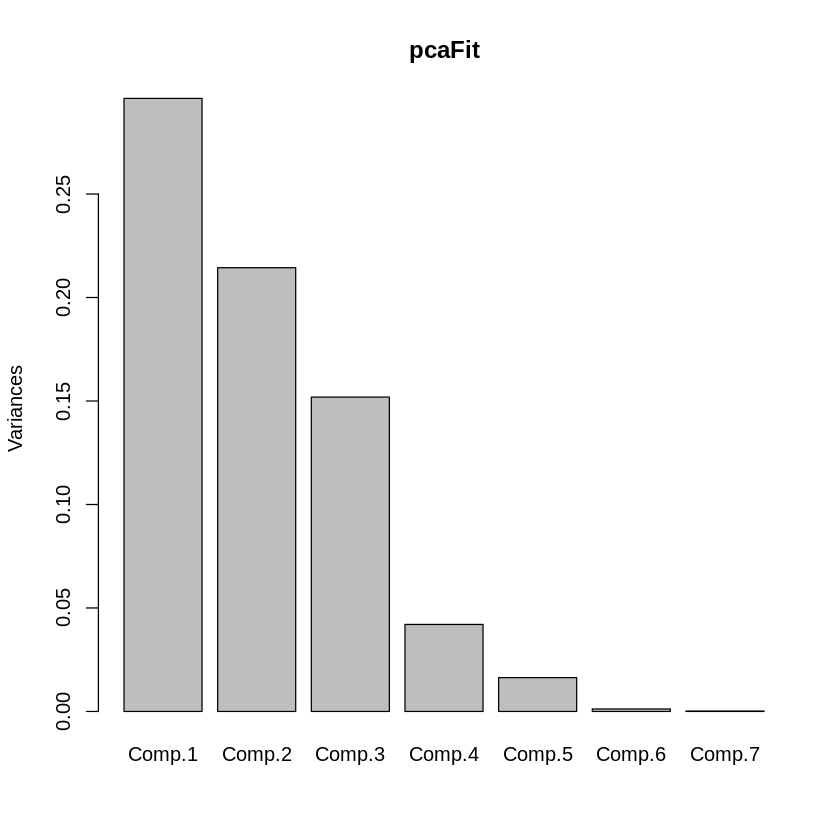

In [166]:
plot(pcaFit)

In [167]:
pca_mosq_components = pcaFit$scores[,1:3]
colnames(pca_mosq_components) = c("pca_species_1","pca_species_2","pca_species_3")
pca_mosq_components = as_tibble(pca_mosq_components)
head(pca_mosq_components)

pca_species_1,pca_species_2,pca_species_3
-0.6494156,0.08530339,-0.2054377
-0.6390055,-0.50154211,0.6041849
-0.6494156,0.08530339,-0.2054377
-0.6390055,-0.50154211,0.6041849
-0.6390055,-0.50154211,0.6041849
-0.6494156,0.08530339,-0.2054377


In [168]:
mosq_by_date = mosq_by_date %>% select(-contains("culex")) %>% bind_cols(pca_mosq_components)
head(mosq_by_date)

date,trap,total_wnv,total_mosq,pca_species_1,pca_species_2,pca_species_3
2007-05-29,T002,0,2,-0.6494156,0.08530339,-0.2054377
2007-05-29,T007,0,1,-0.6390055,-0.50154211,0.6041849
2007-05-29,T015,0,5,-0.6494156,0.08530339,-0.2054377
2007-05-29,T045,0,2,-0.6390055,-0.50154211,0.6041849
2007-05-29,T046,0,1,-0.6390055,-0.50154211,0.6041849
2007-05-29,T048,0,3,-0.6494156,0.08530339,-0.2054377


In [169]:
library(lattice)

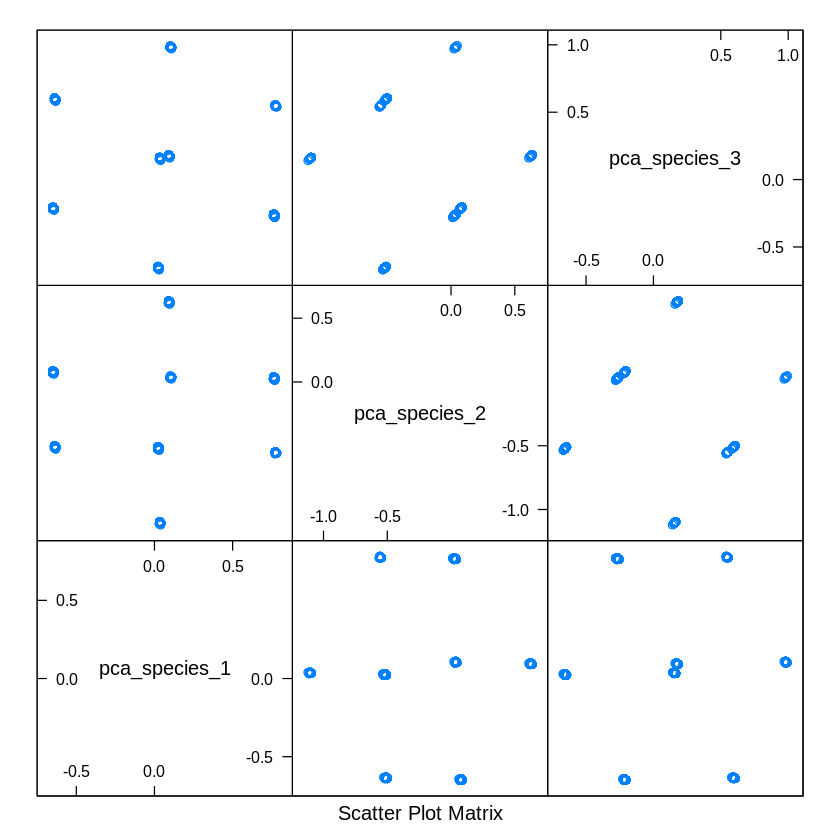

In [170]:
splom(mosq_by_date[,5:7])

In [171]:
## ------------------------------------------------------------------------
trap_metadata = kag_train %>% select(trap, latitude, longitude, address_accuracy, address) %>% distinct()
trap_metadata = trap_metadata %>% mutate(zipcode = stringr::str_extract(address,pattern = "\\d{5}")) %>% select(-address)

In [172]:
## ------------------------------------------------------------------------
head(trap_metadata)

trap,latitude,longitude,address_accuracy,zipcode
T002,41.95469,-87.80099,9,60634
T007,41.99499,-87.76928,9,60646
T015,41.97409,-87.82481,8,60656
T045,41.92160,-87.66645,8,60614
T046,41.89112,-87.65449,8,60654
T048,41.86711,-87.65422,8,60608


Some zipcodes are NA... why? Missing zipcodes or a bad regex?

In [173]:
trap_metadata %>% count(zipcode) %>% tail

zipcode,n
60660,2
60666,1
60707,2
60803,1
60827,1
NA,12


Warning message:
“Ignoring unknown parameters: label.size”Warning message:
“Removed 12 rows containing missing values (geom_text).”

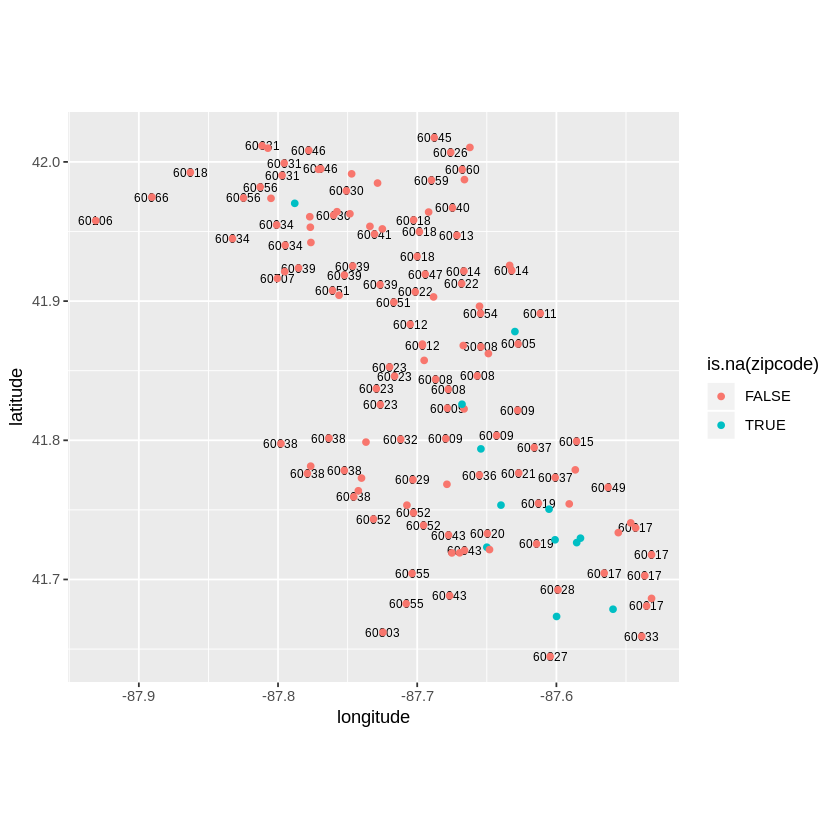

In [174]:
ggplot(trap_metadata,aes(longitude, latitude)) +
    geom_text(aes(label=zipcode),label.size = .1, size = 2.5, check_overlap = T)+
    geom_point(aes(color = is.na(zipcode)))+
    coord_equal()

Let's impute the zipcodes

In [175]:
library("class")

In [176]:
zipcode_is_na = trap_metadata[is.na(trap_metadata$zipcode),]
zipcode_is_na

trap,latitude,longitude,address_accuracy,zipcode
T089,41.72319,-87.64997,5,NA
T145,41.87811,-87.62980,3,NA
T014,41.97025,-87.78799,8,NA
T115,41.67341,-87.59986,5,NA
T138,41.72646,-87.58541,5,NA
T200,41.67862,-87.55931,5,NA
T107,41.72967,-87.58270,5,NA
T102,41.75050,-87.60529,5,NA
T157,41.82590,-87.66783,5,NA
T227,41.72850,-87.60096,5,NA


In [177]:
zipcode_isnot_na = trap_metadata[!is.na(trap_metadata$zipcode),]
train_index = sample(1:nrow(zipcode_isnot_na), 0.8*nrow(zipcode_isnot_na),replace = FALSE)
train_zipcode = zipcode_isnot_na[train_index,]
test_zipcode = zipcode_isnot_na[-train_index,]

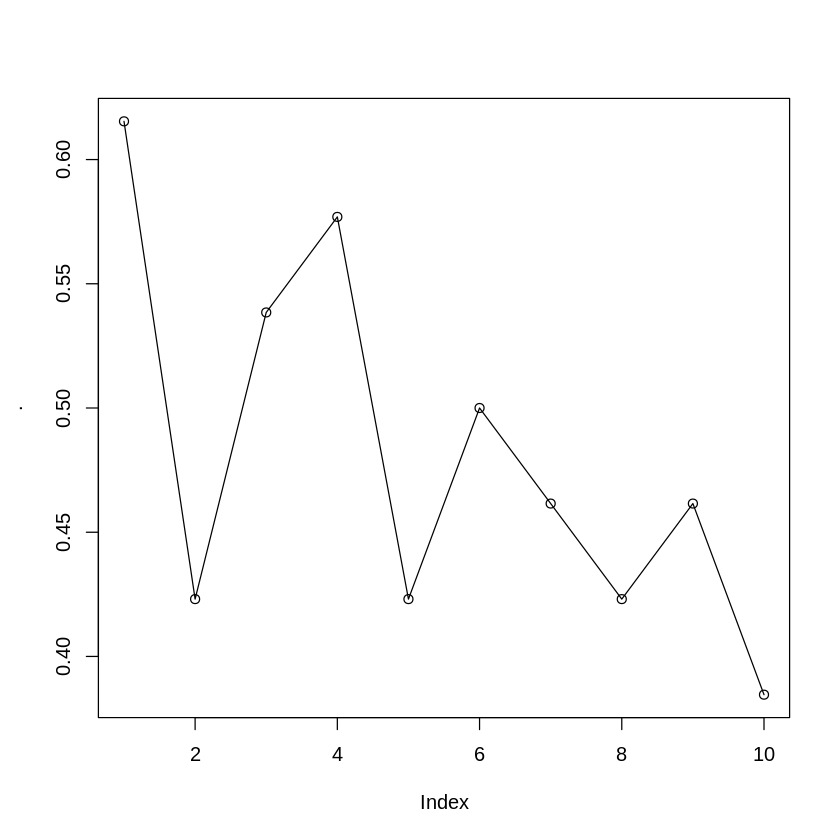

In [178]:
map(1:10,~knn(train_zipcode[,c("latitude","longitude")],test_zipcode[,c("latitude","longitude")],cl = train_zipcode$zipcode,k = .x)) %>%
    map_dbl(~sum(.x==test_zipcode$zipcode) / length(test_zipcode$zipcode)) %>%
    plot(type="o")

In [179]:
knnFit = knn(train_zipcode[,c("latitude","longitude")],test_zipcode[,c("latitude","longitude")] %>% bind_rows(zipcode_is_na[,c("latitude","longitude")]),cl = train_zipcode$zipcode,k = 1)

In [182]:
sum(knnFit[1:nrow(test_zipcode)] == test_zipcode$zipcode)/nrow(test_zipcode)

[1] 0.6153846

In [183]:
trap_metadata$impute = 0
trap_metadata[is.na(trap_metadata$zipcode),"impute"] = 1
trap_metadata[is.na(trap_metadata$zipcode),"zipcode"] = as.character(tail(knnFit,nrow(zipcode_is_na)))

In [186]:
trap_metadata$impute %>% sum()

[1] 12

Warning message:
“Ignoring unknown parameters: label.size”

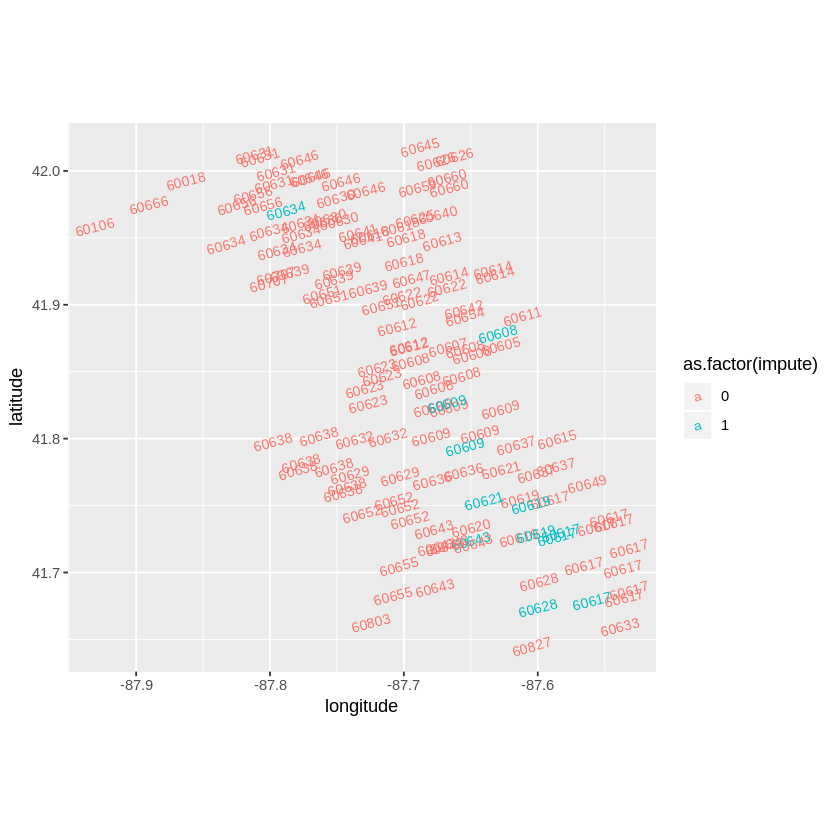

In [189]:
ggplot(trap_metadata) +
    geom_text(aes(longitude, latitude, label=zipcode, color = as.factor(impute)),label.size = .1, size = 3,check_overlap = FALSE, angle = 15)+
    coord_equal()

In [206]:
mosq_by_date %>% left_join(trap_metadata) %>% select(date,zipcode,total_mosq) %>% group_by(date,zipcode) %>% summarize(sum=sum(total_mosq)) %>% ungroup() %>% spread(zipcode,sum,fill=0)-> mosq_count_by_zipcode_over_time

Joining, by = "trap"


In [207]:
head(mosq_count_by_zipcode_over_time)

date,60018,60106,60605,60607,60608,60609,60611,60612,60613,⋯,60652,60654,60655,60656,60659,60660,60666,60707,60803,60827
2007-05-29,0,0,0,0,4,0,3,0,0,⋯,0,1,0,5,0,0,0,0,0,0
2007-06-05,2,0,1,8,7,0,0,0,0,⋯,0,1,11,5,2,1,0,11,7,0
2007-06-26,0,0,0,30,6,0,2,3,0,⋯,0,7,5,1,10,0,0,10,51,0
2007-06-29,0,0,0,10,7,0,0,0,0,⋯,0,2,6,3,3,0,0,6,3,0
2007-07-02,2,0,2,13,8,0,3,16,0,⋯,0,19,33,5,7,2,0,10,30,0
2007-07-11,15,0,6,32,49,38,0,12,0,⋯,0,14,245,19,3,0,0,14,23,0


In [203]:
date_range = seq(min(mosq_count_by_zipcode_over_time$date),max(mosq_count_by_zipcode_over_time$date),by = "days")
head(date_range)

[1] "2007-05-29" "2007-05-30" "2007-05-31" "2007-06-01" "2007-06-02"
[6] "2007-06-03"

In [218]:
mosq_count_by_zipcode_over_time = tibble(date = date_range) %>% left_join(mosq_count_by_zipcode_over_time)

Joining, by = "date"


In [229]:
mosq_count_by_zipcode_over_time[,-1] = mosq_count_by_zipcode_over_time[,-1] %>% mutate_all(.funs = funs(replace(., is.na(.), 0)))
head(mosq_count_by_zipcode_over_time)

date,60018,60106,60605,60607,60608,60609,60611,60612,60613,⋯,60652,60654,60655,60656,60659,60660,60666,60707,60803,60827
2007-05-29,0,0,0,0,4,0,3,0,0,⋯,0,1,0,5,0,0,0,0,0,0
2007-05-30,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2007-05-31,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2007-06-01,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2007-06-02,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2007-06-03,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [238]:
mosq_count_by_zipcode_over_time = mosq_count_by_zipcode_over_time %>% gather(key = "zipcode",value = "total_cases",-date)

Warning message:
“Transformation introduced infinite values in continuous y-axis”

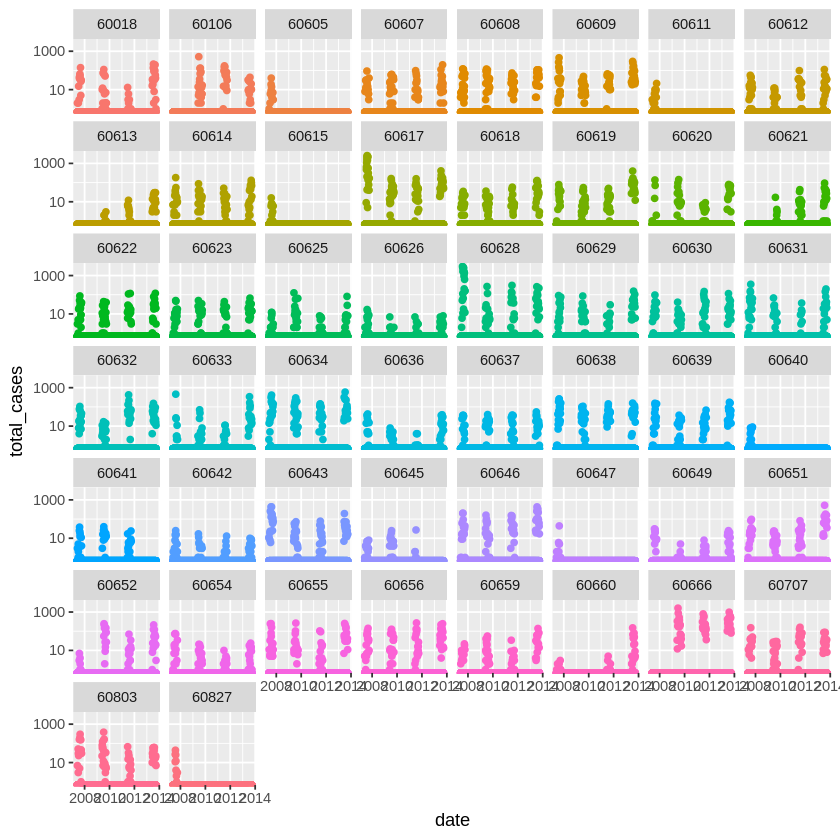

In [241]:
mosq_count_by_zipcode_over_time %>%
    ggplot(aes(date,total_cases,color=zipcode))+
    geom_point()+
    facet_wrap(~zipcode)+
    scale_y_log10() + 
    theme(legend.position = "none")

In [ ]:
## ------------------------------------------------------------------------
ohare = c(41.99,-87.933,662)
midway = c(41.786,-87.752,612)

Haversine distance to get the distance of each trap from the weather station

In [ ]:
## ------------------------------------------------------------------------
hav.dist <- function(long1, lat1, long2, lat2) {
  R <- 6371
  diff.long <- (long2 - long1)
  diff.lat <- (lat2 - lat1)
  a <- sin(diff.lat/2)^2 + cos(lat1) * cos(lat2) * sin(diff.long/2)^2
  b <- 2 * asin(pmin(1, sqrt(a))) 
  d = R * b
  return(d)
}

In [ ]:
## ------------------------------------------------------------------------
trap_metadata %>% 
    mutate(ohare_dist = hav.dist(longitude,ohare[2],latitude,ohare[1]),
           midway_dist = hav.dist(longitude,midway[2],latitude,midway[1])) -> trap_metadata
head(trap_metadata)

Let's only keep the station which is closest to the trap. Then, we'll join the appropriate weather data to this trap.

In [ ]:
trap_metadata = trap_metadata %>% mutate(station = ifelse(ohare_dist < midway_dist, 1, 2)) %>% select(-ohare_dist, -midway_dist)
head(trap_metadata)

In [ ]:
## ------------------------------------------------------------------------
trap_counts = mosq_by_date %>% count(trap)
trap_metadata %>% 
    left_join(trap_counts) %>% 
    ggplot(aes(longitude,latitude,color=n,size=n),alpha=0.4)+
    geom_point()+
    coord_fixed(ratio = 1)

## Import weather data

In [ ]:
## ------------------------------------------------------------------------
weather_data <- read_csv("../data/raw/kaggle/weather.csv")
head(weather_data)

In [ ]:
## ------------------------------------------------------------------------
date_vec = weather_data$Date
int_cols = weather_data %>% select_if(is_numeric) %>% select(-Date)
chr_cols = weather_data %>% select_if(is_character)

In [ ]:
## ------------------------------------------------------------------------
replace_m_with_na <- function(x){
    x[x=="M"] = NA
    x[x=="-"] = NA
    x
}
replace_t_with_na <- function(x){
    x[x=="T"] = NA
    x
}

In [ ]:
## ------------------------------------------------------------------------
int_cols = int_cols %>% purrr::map_df(~replace_m_with_na(.x)) %>% purrr::map_df(~replace_t_with_na(.x))
chr_cols = chr_cols %>% purrr::map_df(~replace_m_with_na(.x)) %>% purrr::map_df(~replace_t_with_na(.x))

In [ ]:
## ------------------------------------------------------------------------
weather_data = tibble(date = date_vec) %>% bind_cols(int_cols, chr_cols)
head(weather_data)

## ------------------------------------------------------------------------
weather_data <- weather_data %>% 
    mutate(
        Sunset = lubridate::fast_strptime(as.character(Sunset),format = "%H%M",lt = FALSE),
        Sunrise = lubridate::fast_strptime(as.character(Sunrise),format = "%H%M",lt = FALSE),
        day_time = as.numeric(Sunset-Sunrise)
    ) %>% 
    select(-Sunset,-Sunrise)

## ------------------------------------------------------------------------
weather_data <- weather_data %>% select(-CodeSum)

In [ ]:
## ------------------------------------------------------------------------
weather_data[,-1] <- weather_data[,-1] %>% purrr::map_df(~as.numeric(.x))
head(weather_data)

In [ ]:
## ------------------------------------------------------------------------
library(missForest)
library(doParallel)
library(foreach)
#cl <- parallel::makeCluster(18)
registerDoParallel(cores = 15)
mfFit <- missForest(xmis = as.matrix(weather_data[,-1]),ntree = 150)

## ------------------------------------------------------------------------
weather_impute = mfFit$ximp
weather_impute = tibble(date = weather_data$date) %>% bind_cols(as_tibble(weather_impute))

## ------------------------------------------------------------------------
head(weather_impute)

In [ ]:
## ------------------------------------------------------------------------
train_X = mosq_by_date %>% 
    left_join(trap_metadata) %>% 
    left_join(weather_impute) %>% 
    select(-latitude, -longitude) %>% 
    separate(date,c("year","month","date")) %>% 
    mutate(SnowFall = round(SnowFall,2)) %>% 
    mutate_at(c("year","month","date"),as.numeric) %>% 
    mutate(trap=as.factor(trap))

In [ ]:
## ------------------------------------------------------------------------
head(train_X)

## ------------------------------------------------------------------------
dim(train_X)

In [ ]:
## ------------------------------------------------------------------------
library(randomForest)
?randomForest
randomForest(x=train_X[,c(-4,-6)],y = train_X[[6]],ntree = 150)